### Generating Data

Below we choose 100 different starting points for the Lorenz system and calculate the trajectory for 8 seconds in time. We will use this to train our neural network. This will allow the network to act as a time-stepper : given a point (x,y,z) it can calculate the new point (x', y', z') dt seconds further in time.

In [42]:
import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
import scipy.io
from mpl_toolkits.mplot3d import Axes3D


# Load data for this system
train_data = scipy.io.loadmat('./data/kuramoto_sivishinky_train.mat')
test_data = scipy.io.loadmat('./data/kuramoto_sivishinky_test.mat')


(256, 251)
(256, 1)
(1, 251)


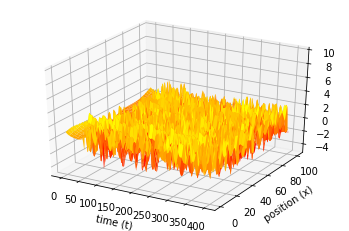

In [43]:
%matplotlib inline

uu = train_data['uu']
x = train_data['x']
tt = train_data['tt']
uu_test = test_data['uu']

print(uu.shape)
print(x.shape)
print(tt.shape)

fig = plt.figure(1)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, uu, cmap='autumn')

plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)

# Construct inputs and expected outputs (i.e. prediction dt into the future)
inputs = uu.T[:-1, :]
outputs = uu.T[1:, :]

### Training A neural Network

Here we define a standard 3-layer feedforward neural network with 20 neurons in each layer

In [32]:
from keras.models import Sequential
from keras.layers import Dense

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(50, activation='relu', input_shape = (uu.shape[0],)))
model.add(Dense(100, activation='tanh'))
model.add(Dense(100, activation='tanh'))
model.add(Dense(50, activation='linear'))

model.add(Dense(uu.shape[0], activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


In [33]:
model.fit(inputs, outputs, 
         epochs=1000,
         batch_size=100,
         shuffle=True, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Train on 200 samples, validate on 50 samples
Epoch 1/1000
200/200 [==============================] - 0s 2ms/step - loss: 1.5227 - val_loss: 1.7454
Epoch 2/1000
200/200 [==============================] - 0s 42us/step - loss: 1.4224 - val_loss: 1.7200
Epoch 3/1000
200/200 [==============================] - 0s 41us/step - loss: 1.3527 - val_loss: 1.7038
Epoch 4/1000
200/200 [==============================] - 0s 42us/step - loss: 1.2953 - val_loss: 1.6894
Epoch 5/1000
200/200 [==============================] - 0s 39us/step - loss: 1.2423 - val_loss: 1.6732
Epoch 6/1000
200/200 [==============================] - 0s 34us/step - loss: 1.1895 - val_loss: 1.6566
Epoch 7/1000
200/200 [==============================] - 0s 34us/step - loss: 1.1388 - val_loss: 1.6382
Epoch 8/1000
200/200 [==============================] - 0s 34us/step - loss: 1.0896 - val_loss: 1.6203
Epoch 9/1000
200/200 [==============================] - 0s 34us/step - loss: 1.0401 - val_loss: 1.6027
Epoch 10/1000
200/200 [======

200/200 [==============================] - 0s 33us/step - loss: 0.1066 - val_loss: 1.5790
Epoch 80/1000
200/200 [==============================] - 0s 32us/step - loss: 0.1046 - val_loss: 1.5792
Epoch 81/1000
200/200 [==============================] - 0s 29us/step - loss: 0.1027 - val_loss: 1.5818
Epoch 82/1000
200/200 [==============================] - 0s 28us/step - loss: 0.1009 - val_loss: 1.5814
Epoch 83/1000
200/200 [==============================] - 0s 36us/step - loss: 0.0991 - val_loss: 1.5832
Epoch 84/1000
200/200 [==============================] - 0s 37us/step - loss: 0.0973 - val_loss: 1.5839
Epoch 85/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0956 - val_loss: 1.5839
Epoch 86/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0939 - val_loss: 1.5861
Epoch 87/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0923 - val_loss: 1.5878
Epoch 88/1000
200/200 [==============================] - 0s 31us/step - loss: 

200/200 [==============================] - 0s 35us/step - loss: 0.0306 - val_loss: 1.6064
Epoch 158/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0302 - val_loss: 1.6074
Epoch 159/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0299 - val_loss: 1.6075
Epoch 160/1000
200/200 [==============================] - 0s 28us/step - loss: 0.0295 - val_loss: 1.6068
Epoch 161/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0292 - val_loss: 1.6081
Epoch 162/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0289 - val_loss: 1.6080
Epoch 163/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0286 - val_loss: 1.6077
Epoch 164/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0283 - val_loss: 1.6077
Epoch 165/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0279 - val_loss: 1.6100
Epoch 166/1000
200/200 [==============================] - 0s 35us/step

200/200 [==============================] - 0s 29us/step - loss: 0.0150 - val_loss: 1.6138
Epoch 236/1000
200/200 [==============================] - 0s 38us/step - loss: 0.0148 - val_loss: 1.6145
Epoch 237/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0147 - val_loss: 1.6136
Epoch 238/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0146 - val_loss: 1.6144
Epoch 239/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0145 - val_loss: 1.6156
Epoch 240/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0144 - val_loss: 1.6140
Epoch 241/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0143 - val_loss: 1.6146
Epoch 242/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0142 - val_loss: 1.6150
Epoch 243/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0141 - val_loss: 1.6141
Epoch 244/1000
200/200 [==============================] - 0s 34us/step

200/200 [==============================] - 0s 30us/step - loss: 0.0087 - val_loss: 1.6178
Epoch 314/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0086 - val_loss: 1.6183
Epoch 315/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0086 - val_loss: 1.6177
Epoch 316/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0085 - val_loss: 1.6187
Epoch 317/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0085 - val_loss: 1.6180
Epoch 318/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0084 - val_loss: 1.6190
Epoch 319/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0084 - val_loss: 1.6168
Epoch 320/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0083 - val_loss: 1.6185
Epoch 321/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0083 - val_loss: 1.6190
Epoch 322/1000
200/200 [==============================] - 0s 33us/step

200/200 [==============================] - 0s 33us/step - loss: 0.0058 - val_loss: 1.6212
Epoch 392/1000
200/200 [==============================] - 0s 29us/step - loss: 0.0058 - val_loss: 1.6208
Epoch 393/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0058 - val_loss: 1.6212
Epoch 394/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0058 - val_loss: 1.6209
Epoch 395/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0057 - val_loss: 1.6219
Epoch 396/1000
200/200 [==============================] - 0s 29us/step - loss: 0.0057 - val_loss: 1.6216
Epoch 397/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0056 - val_loss: 1.6213
Epoch 398/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0056 - val_loss: 1.6210
Epoch 399/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0056 - val_loss: 1.6232
Epoch 400/1000
200/200 [==============================] - 0s 37us/step

200/200 [==============================] - 0s 32us/step - loss: 0.0045 - val_loss: 1.6222
Epoch 470/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0045 - val_loss: 1.6261
Epoch 471/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0045 - val_loss: 1.6230
Epoch 472/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0045 - val_loss: 1.6254
Epoch 473/1000
200/200 [==============================] - 0s 29us/step - loss: 0.0046 - val_loss: 1.6233
Epoch 474/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0045 - val_loss: 1.6249
Epoch 475/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0046 - val_loss: 1.6215
Epoch 476/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0046 - val_loss: 1.6254
Epoch 477/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0046 - val_loss: 1.6226
Epoch 478/1000
200/200 [==============================] - 0s 32us/step

Epoch 547/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0036 - val_loss: 1.6212
Epoch 548/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0036 - val_loss: 1.6263
Epoch 549/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0037 - val_loss: 1.6186
Epoch 550/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0037 - val_loss: 1.6271
Epoch 551/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0037 - val_loss: 1.6169
Epoch 552/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0037 - val_loss: 1.6294
Epoch 553/1000
200/200 [==============================] - 0s 27us/step - loss: 0.0037 - val_loss: 1.6150
Epoch 554/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0038 - val_loss: 1.6273
Epoch 555/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0037 - val_loss: 1.6156
Epoch 556/1000
200/200 [==============================]

200/200 [==============================] - 0s 31us/step - loss: 0.0027 - val_loss: 1.6248
Epoch 626/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0027 - val_loss: 1.6257
Epoch 627/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0027 - val_loss: 1.6241
Epoch 628/1000
200/200 [==============================] - 0s 27us/step - loss: 0.0027 - val_loss: 1.6246
Epoch 629/1000
200/200 [==============================] - 0s 28us/step - loss: 0.0027 - val_loss: 1.6253
Epoch 630/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0027 - val_loss: 1.6250
Epoch 631/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0027 - val_loss: 1.6249
Epoch 632/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0027 - val_loss: 1.6258
Epoch 633/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0027 - val_loss: 1.6246
Epoch 634/1000
200/200 [==============================] - 0s 33us/step

200/200 [==============================] - 0s 33us/step - loss: 0.0024 - val_loss: 1.6284
Epoch 704/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0024 - val_loss: 1.6269
Epoch 705/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0024 - val_loss: 1.6274
Epoch 706/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0023 - val_loss: 1.6291
Epoch 707/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0023 - val_loss: 1.6278
Epoch 708/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0023 - val_loss: 1.6295
Epoch 709/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0024 - val_loss: 1.6277
Epoch 710/1000
200/200 [==============================] - 0s 36us/step - loss: 0.0024 - val_loss: 1.6280
Epoch 711/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0023 - val_loss: 1.6269
Epoch 712/1000
200/200 [==============================] - 0s 38us/step

200/200 [==============================] - 0s 35us/step - loss: 0.0020 - val_loss: 1.6307
Epoch 782/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 1.6275
Epoch 783/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 1.6299
Epoch 784/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 1.6272
Epoch 785/1000
200/200 [==============================] - 0s 39us/step - loss: 0.0020 - val_loss: 1.6302
Epoch 786/1000
200/200 [==============================] - 0s 36us/step - loss: 0.0019 - val_loss: 1.6276
Epoch 787/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0019 - val_loss: 1.6294
Epoch 788/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0019 - val_loss: 1.6284
Epoch 789/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0019 - val_loss: 1.6289
Epoch 790/1000
200/200 [==============================] - 0s 33us/step

200/200 [==============================] - 0s 35us/step - loss: 0.0022 - val_loss: 1.6244
Epoch 860/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0023 - val_loss: 1.6244
Epoch 861/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0022 - val_loss: 1.6225
Epoch 862/1000
200/200 [==============================] - 0s 32us/step - loss: 0.0022 - val_loss: 1.6273
Epoch 863/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0022 - val_loss: 1.6241
Epoch 864/1000
200/200 [==============================] - 0s 30us/step - loss: 0.0021 - val_loss: 1.6277
Epoch 865/1000
200/200 [==============================] - 0s 31us/step - loss: 0.0021 - val_loss: 1.6223
Epoch 866/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0020 - val_loss: 1.6250
Epoch 867/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0020 - val_loss: 1.6228
Epoch 868/1000
200/200 [==============================] - 0s 35us/step

200/200 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 1.6248
Epoch 938/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0015 - val_loss: 1.6245
Epoch 939/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0014 - val_loss: 1.6259
Epoch 940/1000
200/200 [==============================] - 0s 34us/step - loss: 0.0014 - val_loss: 1.6232
Epoch 941/1000
200/200 [==============================] - 0s 37us/step - loss: 0.0014 - val_loss: 1.6261
Epoch 942/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 1.6244
Epoch 943/1000
200/200 [==============================] - 0s 35us/step - loss: 0.0015 - val_loss: 1.6253
Epoch 944/1000
200/200 [==============================] - 0s 36us/step - loss: 0.0015 - val_loss: 1.6241
Epoch 945/1000
200/200 [==============================] - 0s 33us/step - loss: 0.0015 - val_loss: 1.6263
Epoch 946/1000
200/200 [==============================] - 0s 33us/step

### Analyzing Training

Analyze the loss of the neural net (on both the training and validation datasets) as a function of epochs

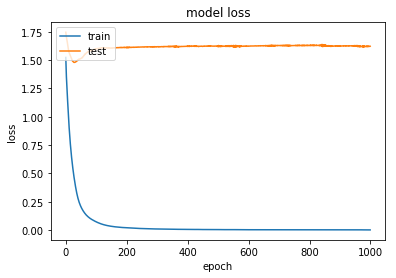

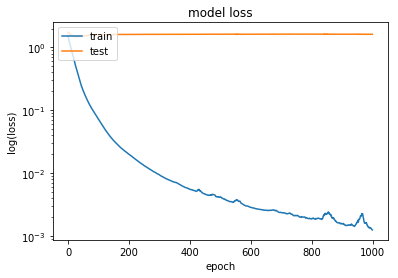

In [34]:
%matplotlib inline

# summarize history for loss
plt.figure(2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(3)
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



### Test Performance of Neural Net

Here, we will generate new trajectories using a random starting condition. Using both an ode solver and our neural network, we will predict the trajectories of the points.

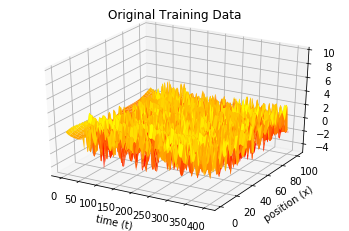

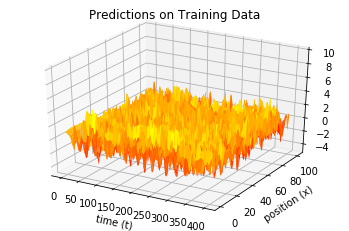

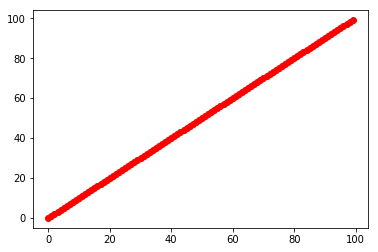

In [48]:
%matplotlib inline

# performance on training data

y_NN = np.zeros(uu.shape)
y_NN[:, 0] = uu[:, 0]

for i in range(1, y_NN.shape[1]):
    y_NN[:, i] = model.predict(np.expand_dims(y_NN[:, i-1], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, uu, cmap='autumn')
plt.title('Original Training Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)

fig = plt.figure(5)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, y_NN, cmap='autumn')
plt.title('Predictions on Training Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)




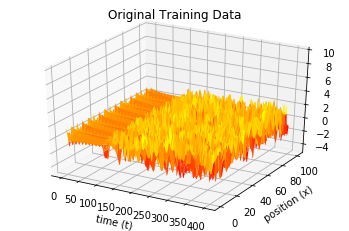

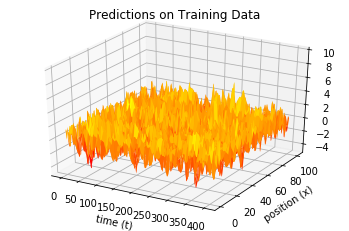

In [45]:
# performance on testing data

y_NN = np.zeros(uu.shape)
y_NN[:, 0] = uu_test[:, 0]

for i in range(1, y_NN.shape[1]):
    y_NN[:, i] = model.predict(np.expand_dims(y_NN[:, i-1], axis=1).T)

    
fig = plt.figure(4)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, uu_test, cmap='autumn')
plt.title('Original Testing Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)

fig = plt.figure(5)
ax = fig.gca(projection='3d')
ax.plot_surface(tt, x, y_NN, cmap='autumn')
plt.title('Predictions on Testing Data')
plt.xlabel('time (t)')
plt.ylabel('position (x)')
ax.set_zlim(-5, 10)

plt.show(block=True)